## 3) Modelisation 1 (Entrainement et Test)

L'objectif de cette phase est de sélectionner et d'entraîner des algorithmes d'apprentissage automatique pour répondre à la problématique centrale : 

### Rappel de la problématique 

*Comment modéliser et prédire efficacement les prix des produits Dior de
Chine, et quels sont les facteurs déterminants qui influencent le pricing dans le secteur du luxe ?*

### Séparation et Préparation
Avant l'entraînement, la totalité du jeu de données est divisée en deux sous-ensembles :

Jeu d'Entraînement (Training Set) : Utilisé pour apprendre les relations entre les caractéristiques (les features) et le prix.

Jeu de Test (Test Set) : Réservé et non utilisé durant l'apprentissage. Il sert uniquement à évaluer la capacité du modèle à généraliser sur des données qu'il n'a jamais vues, simulant ainsi une prédiction sur de nouveaux produits.

### Process 
On va partir sur une approche graduelle : Si un modèle est trop simple on migre vers un autre, et ainsi de suite. On va se limiter à 3 modèles et en citer d'autre pour faire une ouverture.

In [ ]:
# Import
import sys
import os

sys.path.append(os.path.abspath("../src"))
from preprocessing import preprocess_dior
from modelisation import (
    split_data,
    transform_target,
    inverse_transform_target,
    plot_train_test_split,
    plot_target_transformation,
    ohe_encoding,
    count_encoding,
    train_eval_mode
)
from load_data import load_dior

# chargement du dataset
df = load_dior()

C:\Users\poowd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X, y = preprocess_dior(df)

# X -> title + categories
# y -> price et price_eur

In [3]:
X.head()

,category1_code,category2_code,category3_code
0,WOMEN,SMALL LEATHER GOODS,MINI BAGS
1,WOMEN,SMALL LEATHER GOODS,POUCHES
2,WOMEN,MAISON,DECORATIVE PIECES
3,WOMEN,HANDBAGS,HANDBAGS
4,TIMEPIECES,EXCEPTIONAL TIMEPIECES,DIOR GRANDBAL


### Split Train/Test

In [4]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

Shape X_train : (3580, 3)
Shape X_test  : (896, 3)
Shape y_train : (3580, 1)
Shape y_test  : (896, 1)


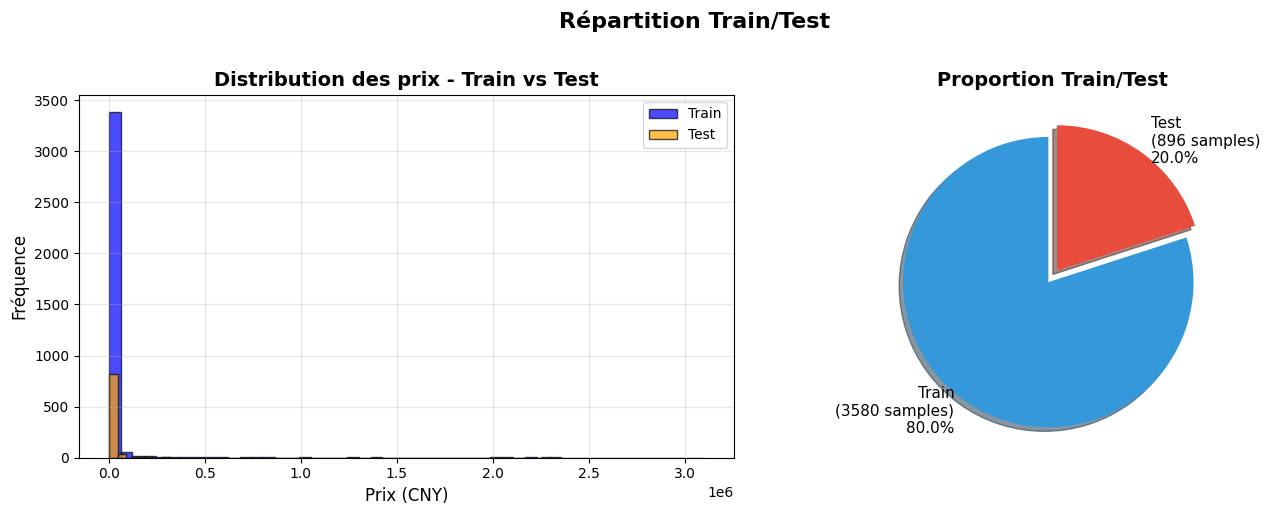

In [5]:
plot_train_test_split(y_train, y_test)

### Standardisation, Normalisation, Log

#### Pourquoi appliquer une transformation logarithmique sur la cible `price` / `price_eur` ?

Dans notre dataset, les prix des produits Dior sont **très déséquilibrés** : on a beaucoup de produits autour de quelques milliers d'euros, mais certains produits peuvent coûter plusieurs centaines de milliers d'euros. Cette distribution très **skewed** (très asymétrique) peut poser problème pour un modèle de régression linéaire classique, car :

1. Le modèle sera **trop influencé par les valeurs extrêmes** (les produits très chers).
2. Les erreurs sur les petites valeurs seront négligées par rapport aux grosses valeurs, ce qui peut rendre la prédiction moins précise sur la majorité des produits.

Pour réduire cet effet, on applique une **transformation logarithmique** sur la cible.  
Formellement, si $y$ représente le prix, on définit :

$$
y_{\text{log}} = \log(y)
$$

où $log$ est le logarithme naturel base $e$

#### Avantages de cette transformation :

- La distribution des prix devient **moins étalée** et plus "normale", ce qui aide le modèle linéaire à mieux s'ajuster.
- Les différences relatives sont prises en compte plutôt que les différences absolues. Par exemple, passer de 100€ à 200€ est considéré de manière similaire à passer de 10 000€ à 20 000€.
- Les résidus du modèle (erreurs) sont mieux répartis, ce qui respecte mieux les hypothèses de la régression linéaire.

#### Après l'entraînement :

Quand on prédit avec le modèle, il faut **retransformer les prédictions** pour revenir à l'échelle des prix réels :

$$
\hat{y} = \exp(\hat{y}_{\text{log}})
$$

où $\hat{y}_{\text{log}}$ est la prédiction du modèle sur la cible log-transformée.

En résumé, la transformation logarithmique permet de **stabiliser la variance** de la cible et d'améliorer la performance du modèle sur des prix très hétérogènes.

In [6]:
y_train_transformed, y_test_transformed, transform_info = transform_target(
    y_train, 
    y_test, 
    method='log'
)

Transformation: log(1 + prix)


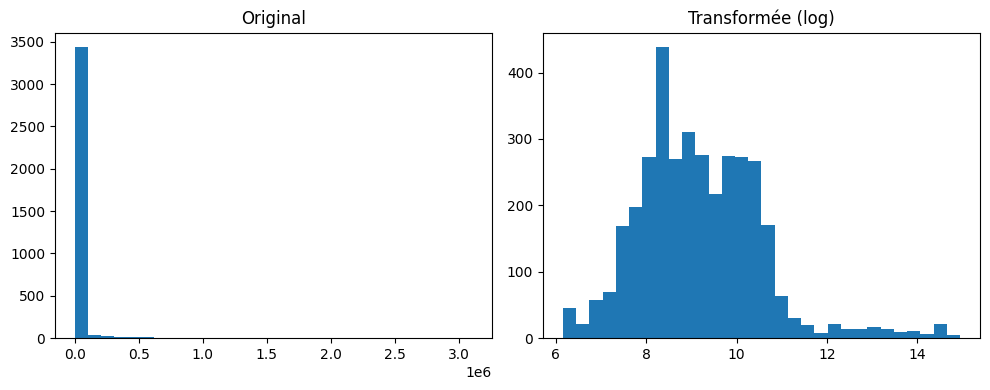

,price
2032,11.884496
4287,10.373522
1790,7.741099
1196,9.711176
696,8.594339
...,...
4448,8.716208
469,7.741099
3109,9.928229
3792,8.556606


In [7]:
plot_target_transformation(y_train, 'log')

### Encodage et transformation

In [8]:
print(X_train['category1_code'].unique())

['TIMEPIECES' 'WOMEN' 'MEN' 'BABY DIOR' 'JEWELLERY']


In [9]:
print(X_train['category2_code'].unique())

['TIMEPIECES' 'CLOTHING' 'JEWELS' 'LEATHER GOODS' 'MAISON' 'ACCESSORIES'
 'GIRLS' 'HANDBAGS' 'JEWELLERY' 'EXCEPTIONAL TIMEPIECES' 'SHOES'
 'BABY BOYS' 'SMALL LEATHER GOODS' 'BOYS' 'BABY GIRLS' 'NEWBORN']


In [10]:
print(X_train['category3_code'].unique())

['GEM DIOR' 'SKIRTS' 'EARRINGS' 'BACKPACKS' 'NECKLACES' 'SHIRTS' 'TEA'
 'TIES' 'HANDBAGS' 'BOWLS' 'TOTES' 'COATS' 'SHORTS' 'BRACELETS'
 'KEY RINGS' 'PLATES' 'SWEATERS' 'DIOR GRANDBAL' 'RINGS' 'GLOVES'
 'JUMPERS' 'ANKLE BOOTS' 'SCARFS' 'WALLETS' 'BROOCHES' 'BRIEFCASE' 'SHOES'
 'READY-TO-WEAR' 'SUNGLASSES' 'MINI BAGS' 'T-SHIRTS' 'DECORATIVE PIECES'
 'SHAWLS' 'CUTLERY' 'SHOULDER BAGS' 'BELTS' 'DRESSES' 'KNITWEAR' 'SANDALS'
 'ACCESSORIES' 'SHOULDER STRAP' 'POUCHES' 'CAPS' 'PUMPS' 'LOAFERS'
 'FLAT SHOES' 'SWEATSHIRTS' 'OBJECTS' 'NOTEBOOKS' 'CANDLES' 'CARD-HOLDERS'
 'SUIT JACKETS' 'HATS' 'SNEAKERS' 'GLASSES' 'BATH LINEN' 'TROUSERS'
 'LA D DE DIOR' 'MICRO BAGS' 'MITZAH' 'CARAFES' 'NEWBORN GIFT SETS'
 'TOTE BAGS' 'BASKETS' 'SWIMSUITS' 'VASES' 'BADGES' 'PET ACCESSORIES'
 'TABLE LINEN' 'MITZAH ABCDIOR' 'DIOR GRAND SOIR' 'TRAYS' 'JACKETS'
 'SQUARES 90X90 CM' 'BLANKETS' 'PASSPORT HOLDER' 'DIOR GRAND BAL' 'BOOTS'
 'STOLES' 'BROOCHES AND ACCESSORIES' 'SCARVES' 'SOCKS' 'BOOTIES'
 'CLIP EARRINGS' 'TRI

In [11]:
# Application du One-Hot encoding sur Category1, 2 et 3_code.

X_train_encoder, X_test_encoder, enc1 = ohe_encoding(X_train, X_test, "category1_code")

In [12]:
X_train_encoder, X_test_encoder, enc2 = count_encoding(X_train_encoder, X_test_encoder, "category2_code")

In [13]:
X_train_encoder, X_test_encoder, enc3 = count_encoding(X_train_encoder, X_test_encoder, "category3_code")

In [14]:
print(X_train_encoder.columns[:20])

Index(['category1_code_BABY DIOR', 'category1_code_JEWELLERY',
       'category1_code_MEN', 'category1_code_TIMEPIECES',
       'category1_code_WOMEN', 'category2_code_count', 'category3_code_count'],
      dtype='object')


In [17]:
print(X_train_encoder.shape)
print(X_test_encoder.shape)


(3580, 7)
(896, 7)


### Entrainement, Test, Prediction

**Choix du modèle : Régression linéaire**
Pour prédire le prix des produits Dior China, nous avons choisi la régression linéaire. Ce modèle est simple et interprétable, ce qui permet de mesurer l’influence de chaque variable sur le prix. La cible (prix) est continue et, après transformation logarithmique et standardisation, sa distribution est adaptée à une modélisation linéaire. De plus, certaines relations entre les caractéristiques (niveau de luxe, type de produit) et le prix semblent globalement linéaires, rendant la régression linéaire appropriée avant d’explorer des modèles plus complexes.

\begin{equation}
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p
\end{equation}

où :
- $\hat{y}$ : valeur prédite par le modèle  
- $x_1, x_2, \dots, x_p$ : variables/features  
- $\beta_1, \beta_2, \dots, \beta_p$ : coefficients appris par le modèle  
- $\beta_0$ : intercept (ordonnée à l'origine)


In [ ]:
# Model de regression lineaire 
from sklearn.linear_model import LinearRegression